In [ ]:
#https://www.ibm.com/blogs/research/2018/09/ai-fairness-360/

In [1]:
!pwd

/home/kali/Documents


In [2]:
!python --version

Python 3.10.7


In [3]:
!ls

520_Project.ipynb  desktop_app	desktop_app-main


In [4]:
!git clone https://github.com/Trusted-AI/AIF360.git


Cloning into 'AIF360'...
remote: Enumerating objects: 3519, done.
remote: Counting objects: 100% (780/780), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 3519 (delta 596), reused 573 (delta 493), pack-reused 2739
Receiving objects: 100% (3519/3519), 7.02 MiB | 19.37 MiB/s, done.
Resolving deltas: 100% (2220/2220), done.


In [5]:
!pip3 install aif360 

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import requests
res = requests.get('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
with open('compas.csv','wb') as file:
    file.write(res.content)

In [9]:
!ls

520_Project.ipynb  AIF360  compas.csv  desktop_app  desktop_app-main


In [11]:
!mv compas.csv ./AIF360/aif360/data

In [44]:
!cp ./AIF360/examples/common_utils.py ./

In [45]:
!ls

520_Project.ipynb  AIF360  common_utils.py  desktop_app  desktop_app-main


In [1]:
%matplotlib inline
# Load all necessary packages
import sys
import numpy as np
from tqdm import tqdm
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from common_utils import compute_metrics

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


In [2]:
!pip3 install 'aif360[AdversarialDebiasing]'

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 588.3/588.3 MB 24.0 MB/s eta 0:00:0100:01

In [3]:
all_metrics =  ["Statistical parity difference",
                   "Average odds difference"]

In [47]:
dataset_orig = CompasDataset()
  # ignore age-related attributes)
#dividing the dataset into train and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)
protected_attribute_names=['sex', 'race']
privileged_classes=[['Female'], ['Caucasian']]

privileged_groups =  [{'sex':1,'race':1}]
unprivileged_groups = [{'sex':0,'race':0}]

In [48]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [49]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(4316, 401)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age_cat=25 - 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'c_charge_degree=F', 'c_charge_degree=M', 'c_charge_desc=Abuse Without Great Harm', 'c_charge_desc=Agg Abuse Elderlly/Disabled Adult', 'c_charge_desc=Agg Assault W/int Com Fel Dome', 'c_charge_desc=Agg Battery Grt/Bod/Harm', 'c_charge_desc=Agg Fleeing and Eluding', 'c_charge_desc=Agg Fleeing/Eluding High Speed', 'c_charge_desc=Aggr Child Abuse-Torture,Punish', 'c_charge_desc=Aggrav Battery w/Deadly Weapon', 'c_charge_desc=Aggrav Child Abuse-Agg Battery', 'c_charge_desc=Aggrav Child Abuse-Causes Harm', 'c_charge_desc=Aggrav Stalking After Injunctn', 'c_charge_desc=Aggravated Assault', 'c_charge_desc=Aggravated Assault W/Dead Weap', 'c_charge_desc=Aggravated Assault W/dead Weap', 'c_charge_desc=Aggravated Assault W/o Firearm', 'c_charge_desc=Aggravated Assault w/Firearm', 'c_charge_desc=Aggravated Battery', 'c_charge_desc=Aggra

In [50]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)
print(dataset_orig_train.favorable_label)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
print(pos_ind)
dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

0.0
0


In [51]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
print(dataset_orig_test_pred.scores)

[[5.62366128e-01]
 [5.72359226e-01]
 [9.08397425e-01]
 [3.25293924e-01]
 [6.92623139e-01]
 [4.34975299e-01]
 [6.63466624e-01]
 [7.66360394e-01]
 [9.95717665e-01]
 [7.41647321e-01]
 [6.04728611e-01]
 [5.26434855e-01]
 [4.95667650e-01]
 [8.47733647e-01]
 [5.55029593e-01]
 [4.45949181e-01]
 [6.37352105e-01]
 [8.91647964e-01]
 [2.72791642e-01]
 [8.37284491e-01]
 [4.69483472e-01]
 [9.01657757e-01]
 [5.77214236e-01]
 [9.97324829e-01]
 [8.45980087e-01]
 [2.02899096e-01]
 [3.90664910e-01]
 [5.98958526e-01]
 [3.71518055e-01]
 [3.98729028e-01]
 [2.60777175e-01]
 [9.16948589e-02]
 [5.72685302e-01]
 [3.44510690e-01]
 [4.62007722e-01]
 [3.77178645e-01]
 [9.96900990e-01]
 [3.29941405e-01]
 [9.98743751e-01]
 [6.08117278e-01]
 [4.87210197e-01]
 [4.16989728e-01]
 [6.37463340e-01]
 [7.62316703e-01]
 [2.58325775e-01]
 [4.47964086e-01]
 [8.45574141e-01]
 [5.77493213e-01]
 [4.20051312e-01]
 [5.30479454e-01]
 [5.70523743e-01]
 [2.73766915e-01]
 [5.77415475e-01]
 [8.53910454e-01]
 [4.72841875e-01]
 [5.510101

In [52]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6794
Optimal classification threshold (no reweighing) = 0.5940


In [53]:

display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])


#### Predictions from original testing data

Classification threshold used = 0.5940


100%|██████████| 100/100 [00:00<00:00, 479.29it/s]

Balanced accuracy = 0.6401
Statistical parity difference = -0.3894
Disparate impact = 0.4705
Average odds difference = -0.3687
Equal opportunity difference = -0.3300
Theil index = 0.2991


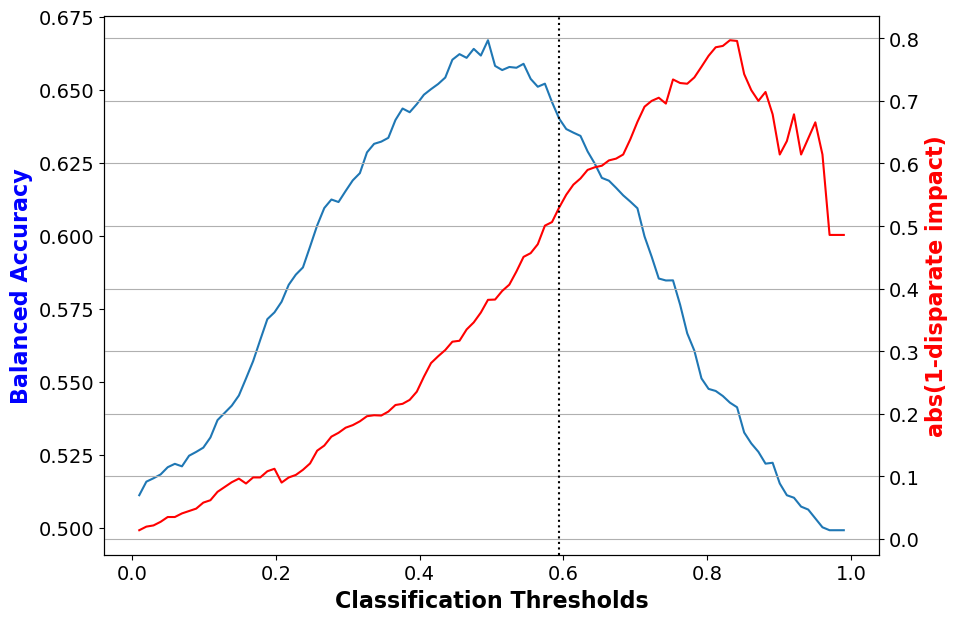

In [54]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

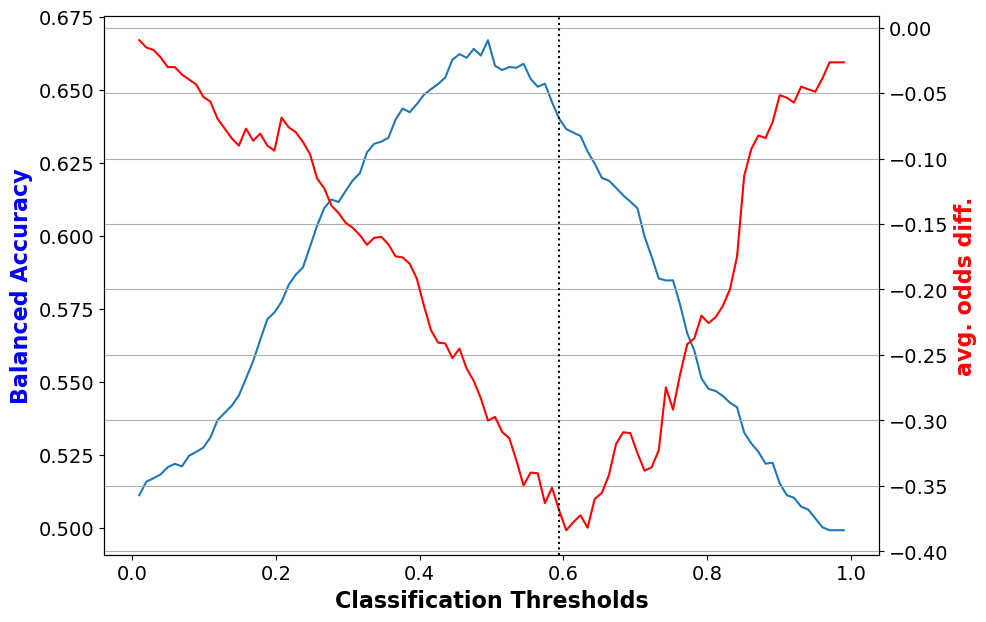

In [55]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [56]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.176968


In [57]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [58]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [59]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [60]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [61]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.5940


100%|██████████| 100/100 [00:00<00:00, 269.06it/s]

Balanced accuracy = 0.6634
Statistical parity difference = -0.0858
Disparate impact = 0.8504
Average odds difference = -0.0539
Equal opportunity difference = -0.0188
Theil index = 0.2392


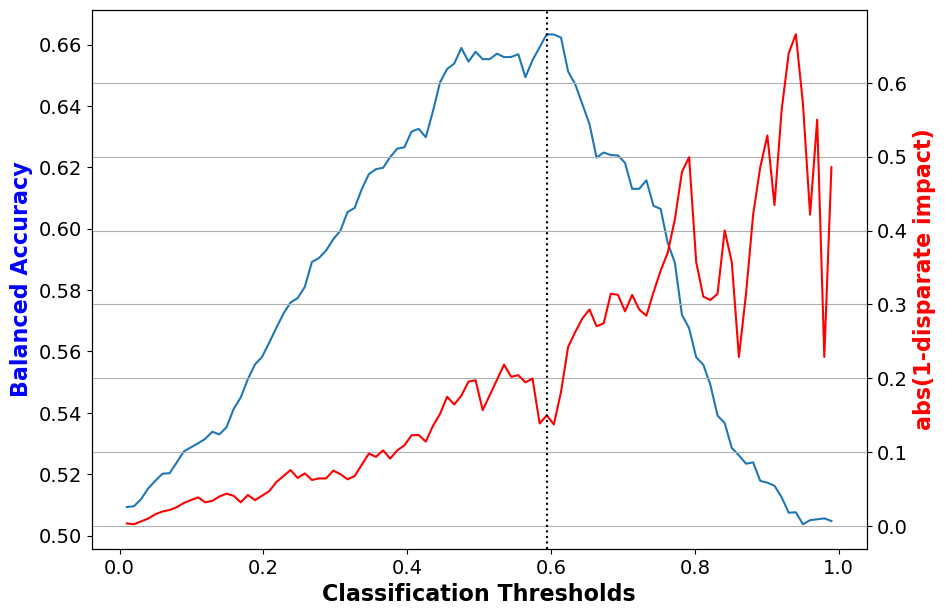

In [62]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

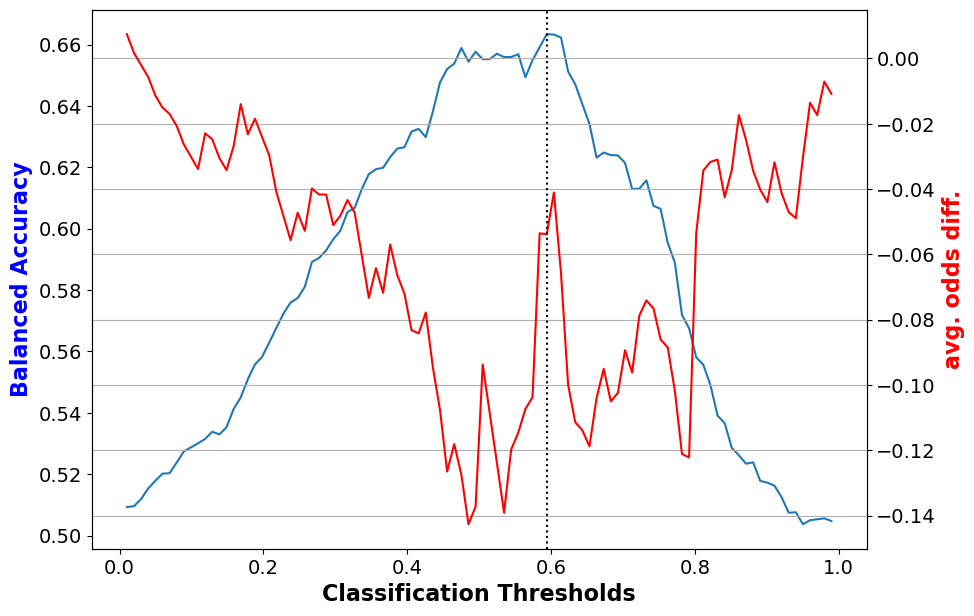

In [63]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)